## TASK 1

In [5]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from captum.insights import AttributionVisualizer, Batch
import numpy as np
import json
from PIL import Image 

In [6]:
import base64
import warnings
from collections import namedtuple
from io import BytesIO
from typing import Callable, List, Optional, Union
from captum._utils.common import safe_div
from captum.attr._utils import visualization as viz
from captum.insights.attr_vis._utils.transforms import format_transforms

FeatureOutput = namedtuple("FeatureOutput", "name base modified type contribution")


def _convert_figure_base64(fig):
    buff = BytesIO()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig.tight_layout()  # removes padding
    fig.savefig(buff, format="png")
    base64img = base64.b64encode(buff.getvalue()).decode("utf-8")
    return base64img

class BaseFeature:
    def __init__(
        self,
        name: str,
        baseline_transforms: Optional[Union[Callable, List[Callable]]],
        input_transforms: Optional[Union[Callable, List[Callable]]],
        visualization_transform: Optional[Callable],
    ) -> None:
        self.name = name
        self.baseline_transforms = format_transforms(baseline_transforms)
        self.input_transforms = format_transforms(input_transforms)
        self.visualization_transform = visualization_transform

    @staticmethod
    def visualization_type() -> str:
        raise NotImplementedError

    def visualize(self, attribution, data, contribution_frac) -> FeatureOutput:
        raise NotImplementedError


class ImageFeature(BaseFeature):
    def __init__(
        self,
        name: str,
        baseline_transforms: Union[Callable, List[Callable]],
        input_transforms: Union[Callable, List[Callable]],
        visualization_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(
            name,
            baseline_transforms=baseline_transforms,
            input_transforms=input_transforms,
            visualization_transform=visualization_transform,
        )

    @staticmethod
    def visualization_type() -> str:
        return "image"

    def visualize(self, attribution, data, contribution_frac) -> FeatureOutput:
        if self.visualization_transform:
            data = self.visualization_transform(data)
            print(data.shape)
        data_t, attribution_t = [
            t.detach().squeeze().cpu().numpy()
            for t in (data, attribution)
        ]
        data_t =data_t.reshape(28,28,1)
        attribution_t = attribution_t.reshape(28,28,1)
        orig_fig, _ = viz.visualize_image_attr(
            attribution_t, data_t, method="original_image", use_pyplot=False #alpha_overlay=True
        )
        attr_fig, _ = viz.visualize_image_attr(
            attribution_t,
            data_t,
            method="heat_map",
            sign="absolute_value",
            use_pyplot=False,
        )
        img_64 = _convert_figure_base64(orig_fig)
        attr_img_64 = _convert_figure_base64(attr_fig)

        return FeatureOutput(
            name=self.name,
            base=img_64,
            modified=attr_img_64,
            type=self.visualization_type(),
            contribution=contribution_frac,
        )

In [68]:
# code 1: Classic version to filter and visualize any classes out of captum insights

def get_classes():
    classes =["top", "trouser", "pullover", "dress", "coat","sandal", "shirt", "sneaker", "bag", "ankle boot"]
    return classes


def get_pretrained_model():
    class FashionCNN(nn.Module):
        def __init__(self):
            super(FashionCNN, self).__init__()

            self.layer1 = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

            self.layer2 = nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )

            self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
            self.drop = nn.Dropout(0.25)
            self.fc2 = nn.Linear(in_features=600, out_features=120)
            self.fc3 = nn.Linear(in_features=120, out_features=10)

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = out.view(out.size(0), -1)
            out = self.fc1(out)
            out = self.drop(out)
            out = self.fc2(out)
            out = self.fc3(out)
            return out

    net = FashionCNN()
    net.load_state_dict(torch.load("C:/Users/Nataka/Desktop/Siddhi_XAI/data/models/FashionMnist_torchvision.pt",map_location=torch.device('cpu')))
    for param in net.parameters():
        param.requires_grad = False
    return net


def baseline_func(input):
    return input * 0


def formatted_data_iter():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((28,28)),
                                transforms.Normalize((0.5, ), (0.5, ))])
    dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
    print(dataset)
    dataloader = iter(
        torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    )
    while True:
        images, labels = next(dataloader)
        #images = images.unsqueeze(0).permute(64,2,0)
        yield Batch(inputs=images, labels=labels)


def full(input):
    return input.reshape(28,28,1) #torch.cat(list(map(lambda i: i, input)), 0) #.squeeze(2)#np.transpose(input.numpy(), (1,2,0))#input.squeeze().detach().cpu()#[i.cpu().detach().numpy().squeeze() for i in input]

def demo(input):
    transform = torchvision.transforms.Compose([
     torchvision.transforms.Resize(28),
     torchvision.transforms.CenterCrop(28),
     torchvision.transforms.ToTensor(),
    ])
    transform_normalize = torchvision.transforms.Normalize(
    mean=[0.485],
    std=[0.229],
    )
    i = Image.open(input).convert('L')
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i

#Main code
normalize = transforms.Normalize((0.5,), (0.5, ))
model = get_pretrained_model()
visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=get_classes(),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
             visualization_transform=None,
            input_transforms=[normalize],
           
        )
    ],
    dataset=formatted_data_iter(),
)
visualizer.render(debug=True)

CaptumInsights(insights_config={'classes': ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', …

Output()

In [17]:
# Code2: For customized version - only following Imgs/classes can be filtered in the captum insights viz

imgs = ['img/pullover_1.jpg', 'img/sneaker_1.jpg', 'img/trouser_1.jpg','img/sneaker_2.jpg']

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
transform = torchvision.transforms.Compose([
 torchvision.transforms.Resize(28),
 torchvision.transforms.CenterCrop(28),
 torchvision.transforms.ToTensor(),
])
transform_normalize = torchvision.transforms.Normalize(
    mean=[0.485],
    std=[0.229],
)

for img in imgs:
    img = Image.open(img).convert('L')
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension
    output = model(input_img).argmax().item()
    prediction_score, pred_label_idx = torch.topk(torch.tensor(output), 1)
    pred_label_idx.squeeze_()
    predicted_label = labelNames[output] # idx_to_labels[str(pred_label_idx.item())][1]
    #print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0


# merging our image transforms from above
def full_img_transform(input):
    transform = torchvision.transforms.Compose([
     torchvision.transforms.Resize(28),
     torchvision.transforms.CenterCrop(28),
     torchvision.transforms.ToTensor(),
    ])
    transform_normalize = torchvision.transforms.Normalize(
    mean=[0.485],
    std=[0.229],
    )
    i = Image.open(input).convert('L')
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)
model = get_pretrained_model()
visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=labelNames, #list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[transform_normalize],
        )
    ],
    dataset=[Batch(input_imgs, labels=[2,7,3,7])]
)
visualizer.render(debug=True)

CaptumInsights(insights_config={'classes': ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', …

Output()

## TASK 2

In [54]:
from captum.robust import FGSM
from captum.robust import PGD
from matplotlib import pyplot as plt

classes= ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
transform = torchvision.transforms.Compose([
 torchvision.transforms.Resize(28),
 torchvision.transforms.CenterCrop(28),
 torchvision.transforms.ToTensor(),
])
transform_normalize = torchvision.transforms.Normalize(
    mean=[0.485],
    std=[0.229],
)

def image_show(img, pred):
    npimg = img.squeeze().detach().numpy()
    plt.imshow(npimg)
    plt.title("prediction: %s" % pred)
    plt.show()
    
def get_prediction(model, input, normalize_im=False):
    if normalize_im:
        input = normalize(input)
    output = model(input)
    _, pred = torch.max(output, dim=1)
    return classes[pred], torch.nn.functional.softmax(output)[:,pred]

#Image to be attcked
test_img = 'img/pullover_1.jpg'
img = Image.open(test_img).convert('L')
transformed_img = transform(img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension
output = model(input_img).argmax().item()
prediction_score, pred_label_idx = torch.topk(torch.tensor(output), 1)
pred_label_idx.squeeze_()
predicted_label = classes[output] 
#print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

C:\Users\Nataka\AppData\Local\Temp\ipykernel_34128\3769209386.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return classes[pred], torch.nn.functional.softmax(output)[:,pred]


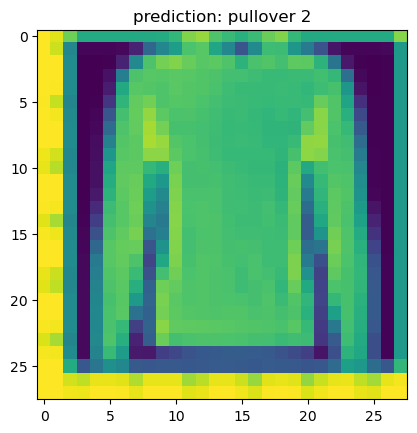

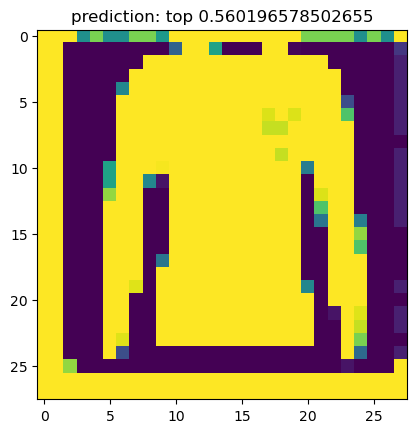

In [59]:
 # Construct FGSM attacker
model = get_pretrained_model()
unnormalize = lambda x: 0.5*x + 0.5
fgsm = FGSM(model, lower_bound=-1, upper_bound=1)
perturbed_image_fgsm = fgsm.perturb(transform_normalize(input_img), epsilon=0.30, target=2) 
new_pred_fgsm, score_fgsm = get_prediction(model, perturbed_image_fgsm)

image_show(input_img, predicted_label+ " " + str(prediction_score.item()))
image_show(unnormalize(perturbed_image_fgsm), new_pred_fgsm + " " + str(score_fgsm.item()))

In [45]:
from captum.robust import AttackComparator
import collections

ModelResult = collections.namedtuple('ModelResults', 'accuracy logit softmax')

def metric(model_out, target):
    if isinstance(target, int):
        target = torch.tensor([target])
    reshaped_target = target.reshape(len(target), 1)
    logit = torch.gather(model_out, 1, reshaped_target).detach()
    _, pred = torch.max(model_out, dim=1)
    acc = (pred == target).float()
    softmax_score =torch.gather(torch.nn.functional.softmax(model_out), 1, reshaped_target).detach()
    return ModelResult(accuracy=acc, logit=logit, softmax=softmax_score)
comparator = AttackComparator(forward_func=model, metric=metric, preproc_fn=normalize)
comparator.add_attack(transforms.RandomRotation(degrees=30), "Random Rotation", num_attempts=100)
comparator.add_attack(transforms.GaussianBlur(kernel_size=3), "Gaussian Blur", num_attempts=1)
comparator.add_attack(fgsm, "FGSM", attack_kwargs={"epsilon": 0.15}, 
                      apply_before_preproc=False, additional_attack_arg_names=["target"], num_attempts=1)
comparator.evaluate(input_img, target=2)

C:\Users\Nataka\AppData\Local\Temp\ipykernel_34128\3695937579.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_score =torch.gather(torch.nn.functional.softmax(model_out), 1, reshaped_target).detach()


{'Original': ModelResults(accuracy=tensor([0.]), logit=tensor([[4.5420]]), softmax=tensor([[5.2781e-05]])),
 'Random Rotation': {'mean': ModelResults(accuracy=tensor([0.]), logit=tensor([[-7.1724]]), softmax=tensor([[3.6906e-06]])),
  'max': ModelResults(accuracy=tensor([0.]), logit=tensor([[4.5420]]), softmax=tensor([[5.2781e-05]])),
  'min': ModelResults(accuracy=tensor([0.]), logit=tensor([[-18.8308]]), softmax=tensor([[1.7939e-21]]))},
 'Gaussian Blur': {'mean': ModelResults(accuracy=tensor([0.]), logit=tensor([[1.4972]]), softmax=tensor([[3.3599e-05]]))},
 'FGSM': {'mean': ModelResults(accuracy=tensor([1.]), logit=tensor([[5.1389]]), softmax=tensor([[0.6207]]))}}

torch.Size([1, 1, 28, 28])
(28, 28, 1)


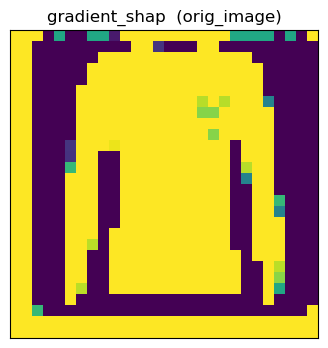

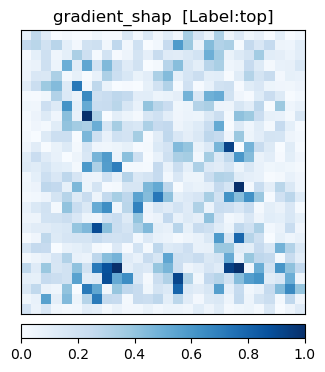

In [67]:
from captum.attr import LimeBase, LRP, KernelShap, DeepLiftShap, IntegratedGradients, GradientShap, DeepLift
from captum.attr import visualization as vis
from PIL import Image 
import torchvision.transforms as T

#Prepare input

sample_input = perturbed_image_fgsm
target_label = 2
prediction = model(sample_input) #torch.tensor(prediction[0].argmax().item())

def explainer_vis(algorithm, sample_input):
    prediction = model(sample_input)
    model.eval()
    explainer = algorithm(model)
    if algorithm in [GradientShap, IntegratedGradients, DeepLiftShap]:
        attribution = explainer.attribute( sample_input, target=target_label, baselines=torch.zeros_like(sample_input[:1])).cpu().numpy().squeeze()
    if algorithm in [DeepLift]:
        attribution = explainer.attribute( sample_input, target=target_label).cpu().detach().numpy().squeeze()
    print(sample_input.shape)
    orig_image = np.transpose(sample_input.reshape(1,28,28).numpy(), (1,2,0))
    print(orig_image.shape)
    
    labelNames = ["top", "trouser", "pullover", "dress", "coat","sandal", "shirt", "sneaker", "bag", "ankle boot"]
    vis.visualize_image_attr(None, orig_image, method="original_image",
                         title=str(algorithm.__module__[18:])+ "  (orig_image)",fig_size=(4,4));
    vis.visualize_image_attr(attribution.reshape(28,28,1),orig_image,
                         show_colorbar=True, cmap="Blues", title=str(algorithm.__module__[18:])+"  [Label:"+ str(new_pred_fgsm)+"]", fig_size=(4,4));

#explainer_vis(GradientShap,1)
#explainer_vis(DeepLiftShap,1)
explainer_vis(GradientShap,sample_input)